### Check astrometry and photometry on "src" catalogs

In [7]:
import lsst.daf.persistence as dafPersist
import lsst.afw.table as afwTable
import lsst.afw.geom as afwGeom
import lsst.afw.image as afwImage

# List of visits to be considered
#visits = [849375, 850587, 907254, 995367, 996234, 850181, 906675, 912206, 995974, 996717]
# visits = [781215, 858793, 860011, 967616, 967871, 967967]
visits = [796221,793169,838864, 849375, 895369, 918238, 996230]

# Reference visit
ref = 796221

# List of CCD to be considered (source calatlogs will be concatenated)
#ccd = [12, 13, 14, 21, 22, 23]
ccd = range(36)
# ccd = [21, 22]
#ccd = [14]

filter = 'r'

Flags = ["base_PixelFlags_flag_saturated", "base_PixelFlags_flag_cr", "base_PixelFlags_flag_interpolated",
         "base_PsfFlux_flag_edge", "base_ClassificationExtendedness_flag", "base_PsfFlux_flag"]

#setup butler - Replace path name by something suitable for you
butler = dafPersist.Butler("/home/boutigny/LSST/CFHT/D3/output2")
#butler = dafPersist.Butler("/sps/lsst/dev/lsstprod/clusters/CL0016+16/output")

for indx, c in enumerate(ccd) :
    dataid = {'visit':ref, 'filter':filter, 'ccd':c}
    oldSrc = butler.get('src', dataid, immediate=True)
#    print c, len(oldSrc)
    if indx == 0 :
        # retrieve the schema of the source catalog and extend it in order to add a field to record the ccd number
        oldSchema = oldSrc.getSchema()
        mapper = afwTable.SchemaMapper(oldSchema)
        mapper.addMinimalSchema(oldSchema)
        newSchema = mapper.getOutputSchema()
        newSchema.addField("ccd", type=int, doc="CCD number")
        
        #create the new extented source catalog 
        srcRef = afwTable.SourceCatalog(newSchema)
        
        flagKey = [newSchema[k].asKey() for k in Flags]
        ccdKey = newSchema["ccd"].asKey()
        extKey = newSchema["base_ClassificationExtendedness_value"].asKey()
        fluxKey = newSchema["base_PsfFlux_flux"].asKey()
        fluxSigmaKey = newSchema["base_PsfFlux_fluxSigma"].asKey()
    
    # create temporary catalog
    tmpCat = afwTable.SourceCatalog(srcRef.table)
    tmpCat.extend(oldSrc, mapper=mapper)
    # fill in the ccd information in numpy mode in order to be efficient
    tmpCat['ccd'][:] = c
    # append the temporary catalog to the extended source catalog    
    srcRef.extend(tmpCat, deep=False)

print "Ref...", len(srcRef)

mag = []
dist = []
diffMag = []
_visits = []
_ccd = []
_ccdR = []
for v in visits :
    if v == ref :
        calibR = []
        for c in range(36) :
            did = {'visit':ref, 'filter':filter, 'ccd':c}
            md = butler.get("calexp_md", did, immediate=True)
            calibR.append(afwImage.Calib(md))
        continue
    srcVis = afwTable.SourceCatalog(newSchema)
    for indx, c in enumerate(ccd) :
        dataid = {'visit':v, 'filter':filter, 'ccd':c}
        try :
            oldSrc = butler.get('src', dataid, immediate=True)
        except :
            print "bad ccd", v, c
            continue
        
        # create temporary catalog
        tmpCat = afwTable.SourceCatalog(srcVis.table)
        tmpCat.extend(oldSrc, mapper=mapper)
        # fill in the ccd information in numpy mode in order to be efficient
        tmpCat['ccd'][:] = c
        # append the temporary catalog to the extended source catalog    
        srcVis.extend(tmpCat, deep=False)
    
    match = afwTable.matchRaDec(srcRef, srcVis, afwGeom.Angle(1./3600., afwGeom.degrees))
    print "Visit :", v, len(match), "matches found"
    
    # Store calibration object associated to each CCD
    calibV = []
    for c in range(36) :
        did = {'visit':v, 'filter':filter, 'ccd':c}
        try :
            md = butler.get("calexp_md", did, immediate=True)
        except :
            calibV.append(None)
            continue
        calibV.append(afwImage.Calib(md))
                
    for m in match :
        mRef = m.first
        mVis = m.second
        
        for f in flagKey :
            if mRef.get(f) or mVis.get(f) :
                continue
        
        # cleanup the reference sources in order to keep only decent star-like objects
        if mRef.get(extKey) > 0.5 or mVis.get(extKey) > 0.5 :
            continue
        
        ang = afwGeom.radToMas(m.distance)
        
        # retrieve the CCD corresponding to the reference source
        ccdRef = mRef.get(ccdKey)
        # compute magnitude
        fluxR = mRef.get(fluxKey)
        fluxErrR = mRef.get(fluxSigmaKey)
        if fluxR < 0 or fluxR/fluxErrR < 6.0 :
            continue
        refMag = calibR[ccdRef].getMagnitude(mRef.get(fluxKey))
                
        ccdV = mVis.get(ccdKey)
        # compute magnitude
        fluxV = mRef.get(fluxKey)
        fluxErrV = mRef.get(fluxSigmaKey)
        if fluxV < 0 or fluxV/fluxErrV < 6.0 :
            continue
        if mVis.get(fluxKey) < 0 :
            continue
        vMag = calibV[ccdV].getMagnitude(mVis.get(fluxKey))
                                    
        mag.append(refMag)
        diffMag.append(vMag-refMag)
        dist.append(ang)
        _ccd.append(ccdV)
        _visits.append(v)
        _ccdR.append(ccdRef)
        
        if refMag<20 and ang>400 :
            print v, ang, refMag, ccdRef, mRef.get('coord_ra'), mRef.get('coord_dec'), mRef.get('base_SdssCentroid_x'), mRef.get('base_SdssCentroid_y'), mVis.get('base_SdssCentroid_x'), mVis.get('base_SdssCentroid_y')
            print mVis.get('base_PixelFlags_flag_edge')

Ref... 56656
Visit : 793169 47105 matches found
793169 653.518214192 17.3433322004 30 3.75339 rad 0.911181 rad 910.027455984 524.556064763 857.0 5.0
True
793169 839.105627197 19.2520342951 24 3.74228 rad 0.915709 rad 2039.0 552.0 1988.09877107 43.0924445322
False
793169 565.573070824 18.9123704725 23 3.74579 rad 0.919334 rad 1763.14906105 4539.35058496 1703.67768081 4030.52171776
False
793169 927.413249242 18.4726717483 13 3.75151 rad 0.919487 rad 1986.65785872 4582.83566717 5.0 4178.0
True
793169 662.526941204 19.2196525832 14 3.74831 rad 0.922945 rad 1981.20102661 760.756064587 2042.0 1272.0
True
793169 935.673221033 18.189180748 4 3.74884 rad 0.924484 rad 227.520653558 4098.07922382 293.0 4606.0
True
793169 696.816387856 17.0128601137 4 3.75146 rad 0.924939 rad 1971.0 3598.0 2035.0 4110.0
True
793169 566.307538259 18.8912541425 0 3.76122 rad 0.925022 rad 8.0 3472.0 69.4575152559 3995.7964024
False
Visit : 838864 51238 matches found
838864 578.316093961 19.9540172117 31 3.75028 rad 0

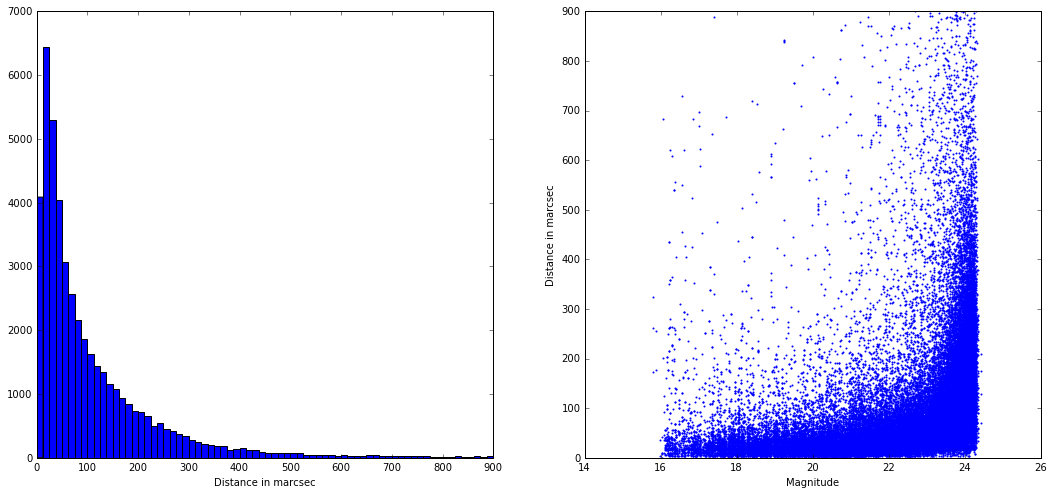

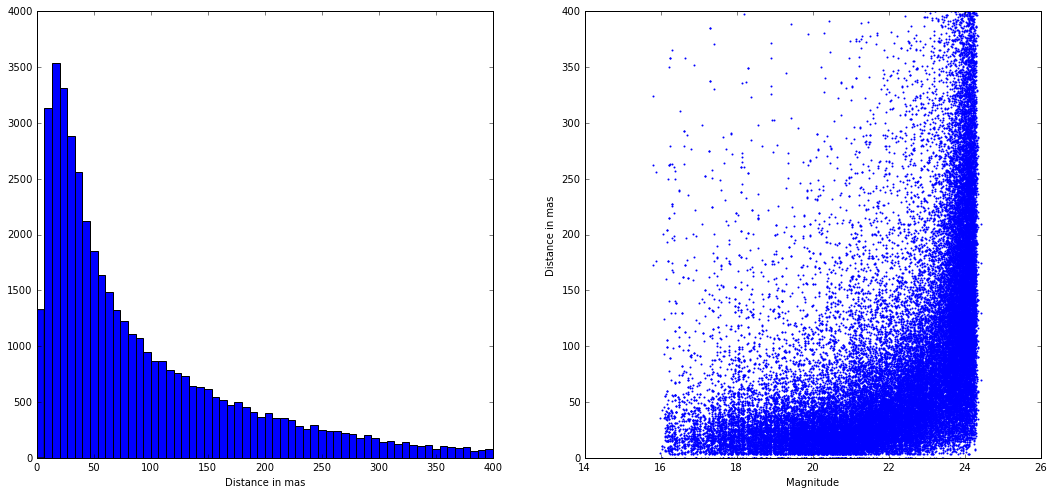

Median value of the astrometric scatter : 63.5496599746 mas


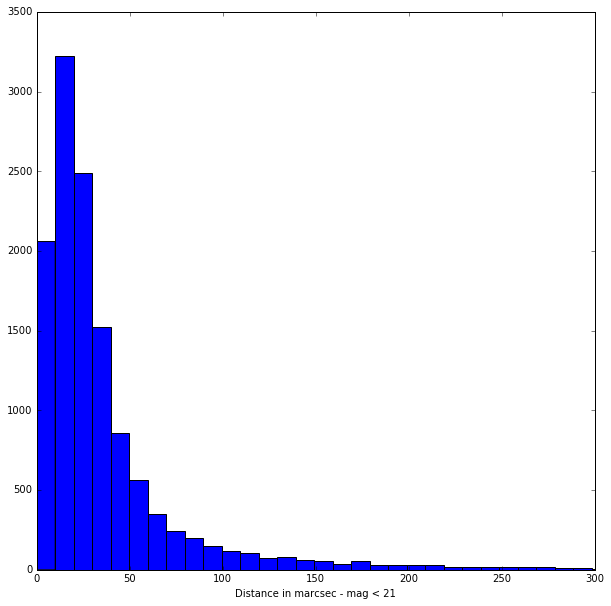

Astrometric scatter (median) - mag < 21 : 23.6086553252 mas


In [8]:
%matplotlib inline
import matplotlib
import matplotlib.pylab as plt
import numpy as np

# Plot distance between sources in different exposures
plt.clf()
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(18, 8))
ax0.hist(dist, bins=80)
ax1.scatter(mag, dist, s=1, color='b')
ax0.set_xlim([0., 900.])
ax0.set_xlabel("Distance in marcsec")
ax1.set_xlabel("Magnitude")
ax1.set_ylabel("Distance in marcsec")
ax1.set_ylim([0., 900.])
plt.show()

plt.clf()
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(18, 8))
ax0.hist(dist,bins=150)
ax0.set_xlim([0.,400.])
ax1.scatter(mag, dist, s=1, color='b')
ax1.set_ylim([0.,400.])
ax0.set_xlabel("Distance in mas")
ax1.set_xlabel("Magnitude")
ax1.set_ylabel("Distance in mas")
plt.show()

print "Median value of the astrometric scatter :", np.median(dist), "mas"

idxs = np.where(np.asarray(mag) < 21)
plt.clf()
fig, ax0 = plt.subplots(ncols=1, figsize=(10,10))
ax0.hist(np.asarray(dist)[idxs], bins=100)
ax0.set_xlabel("Distance in marcsec - mag < 21")
ax0.set_xlim([0,300])
plt.show()

print "Astrometric scatter (median) - mag < 21 :", np.median(np.asarray(dist)[idxs]), "mas"

[  1.06835293e+03   3.03392668e-04  -1.40477224e-02] Both actual and predicted relative reductions in the sum of squares
  are at most 0.000000 1
mean 0.000303 - sigma -0.014048
Reduced chi2 =  5.76196853897


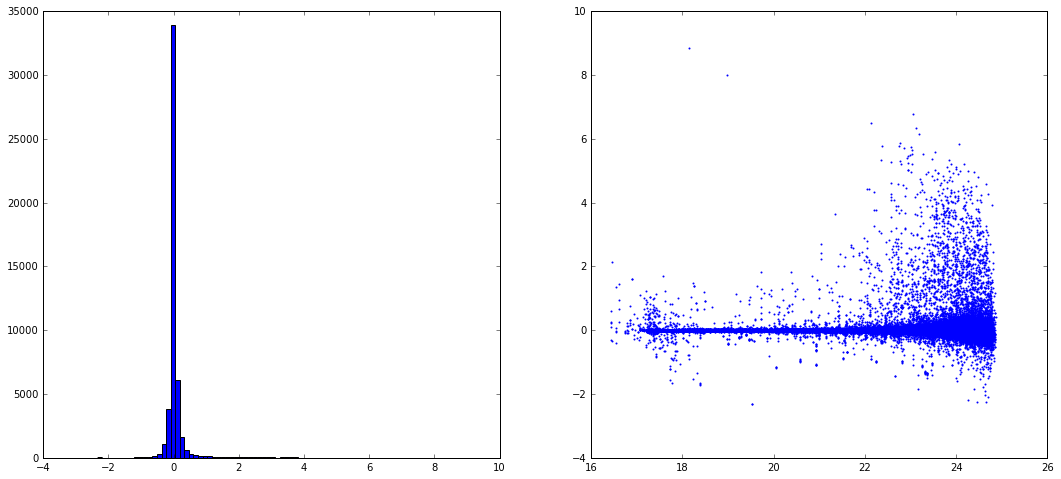

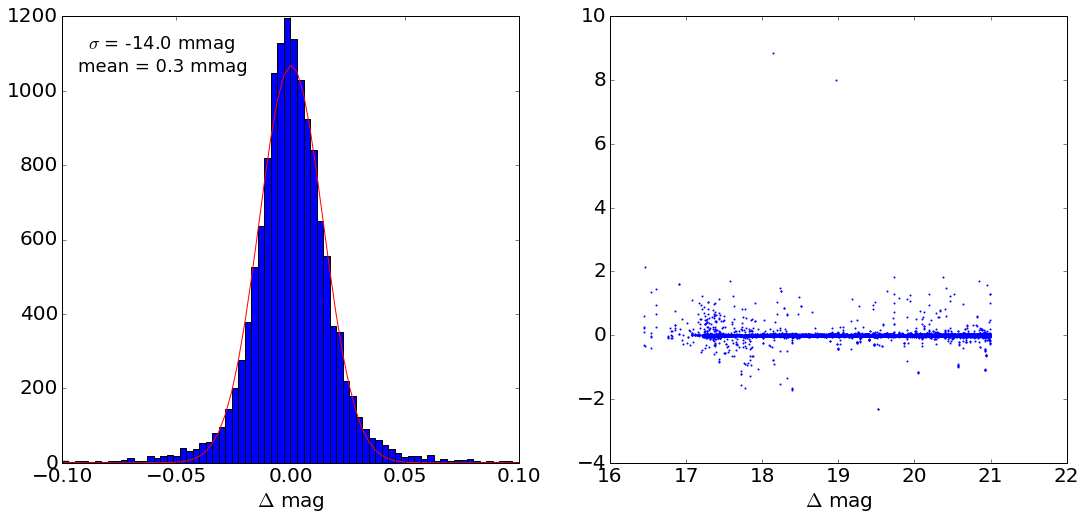

In [7]:
%matplotlib inline
import matplotlib
import matplotlib.pylab as plt
import numpy as np
from scipy import optimize

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(18, 8))
ax0.hist(diffMag, bins=80)
ax1.scatter(mag, diffMag, s=1, color='b')

idxs = np.where(np.asarray(mag) < 21)
med = np.median(np.asarray(diffMag)[idxs])
sig = np.std(np.asarray(diffMag)[idxs])
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(18, 8))
nbins = 70
n, bins, patches = ax0.hist(np.asarray(diffMag)[idxs], bins=nbins, range=[-0.10,0.10])
ax1.scatter(np.asarray(mag)[idxs], np.asarray(diffMag)[idxs], s=1, color='b')
ax1.set_xlabel("mag", fontsize=20)
ax1.set_xlabel("$\Delta$ mag", fontsize=20)
ax1.tick_params(labelsize=20)

max = n.max()
x = [0.5*(bins[i+1]-bins[i])+bins[i] for i in range(len(n))]

gauss = lambda p, x: p[0]*np.exp(-(p[1]-x)**2/(2*p[2]**2))
dist = lambda p, x, y: (gauss(p, x) - y)/(np.sqrt(y)+1)
p0 = [max, 0., 0.1]
p1,cov,infodict,mesg,ier = optimize.leastsq(dist, p0[:], args=(x, n), full_output=True)
print p1, mesg, ier
ss_err=(infodict['fvec']**2).sum()
#ss_tot=((n-n.mean())**2).sum()
#rsquared=1-(ss_err/ss_tot)
print "mean %f - sigma %f"%(p1[1], p1[2])
print "Reduced chi2 = ", ss_err/(nbins+3-1)
ax0.plot(bins, gauss(p1,bins), color='r')
ax0.set_xlim([-0.1,0.1])
ax0.set_xlabel("$\Delta$ mag", fontsize=20)
ax0.set_title("$\sigma$ = %.1f mmag \nmean = %.1f mmag"%(p1[2]*1000, p1[1]*1000), x=0.22, y=0.87, fontsize=18)
ax0.tick_params(labelsize=20)

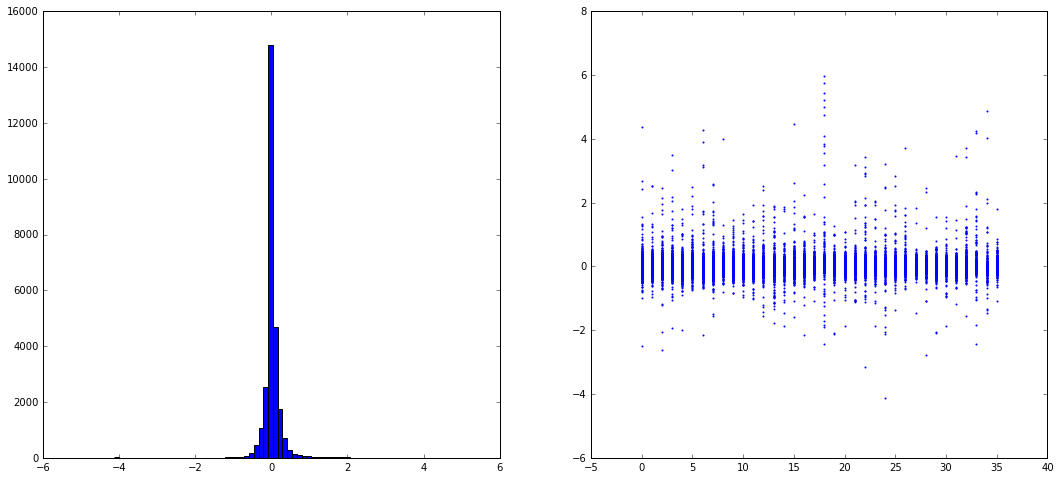

In [4]:
%matplotlib inline
import matplotlib
import matplotlib.pylab as plt
import numpy as np

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(18, 8))
ax0.hist(diffMag, bins=80)
ax1.scatter(_ccd, diffMag, s=1, color='b')


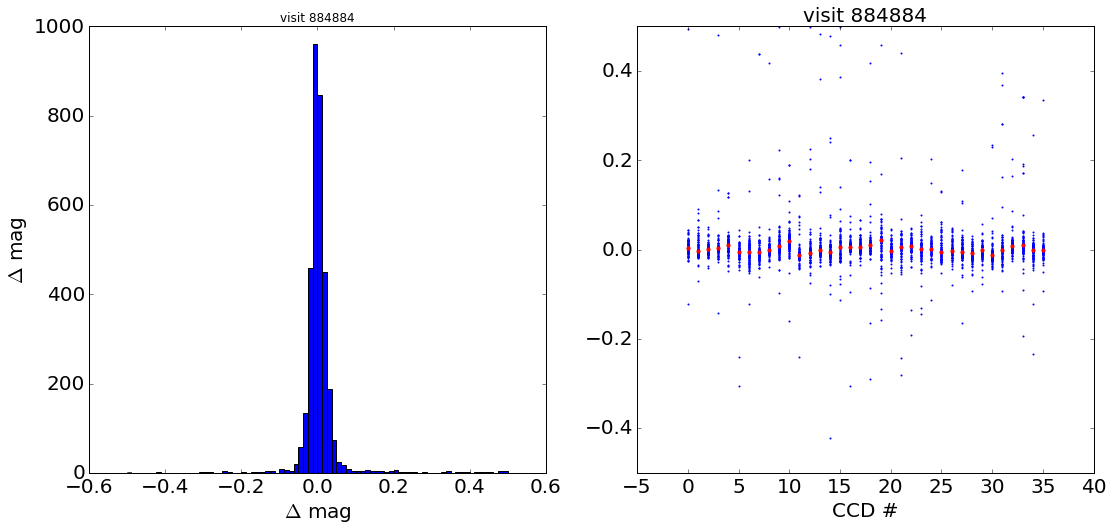

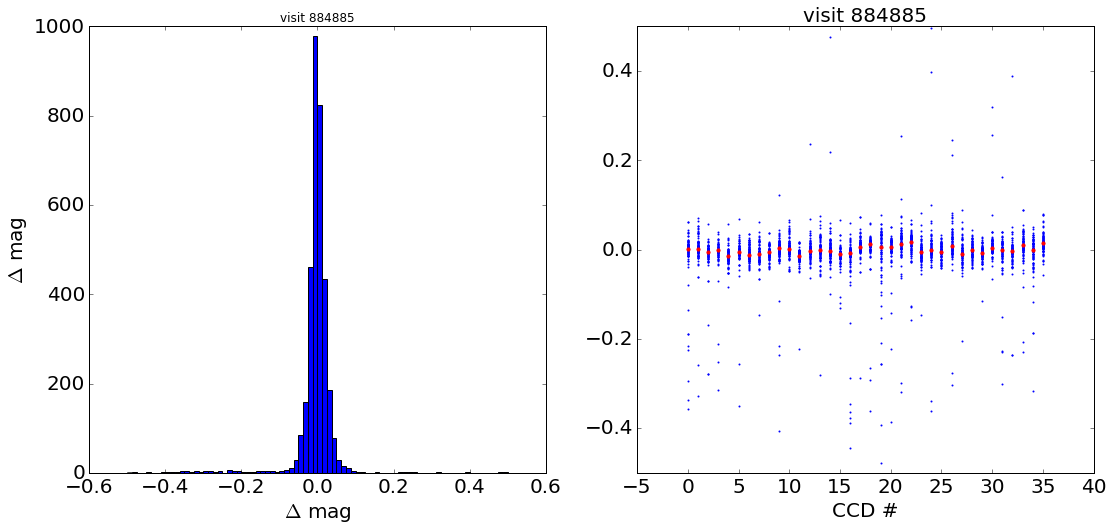

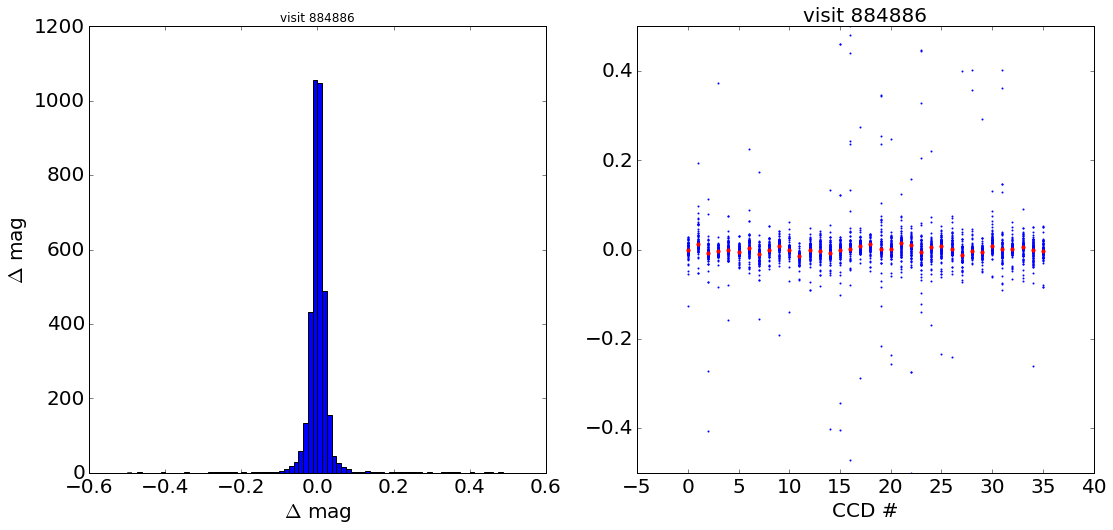

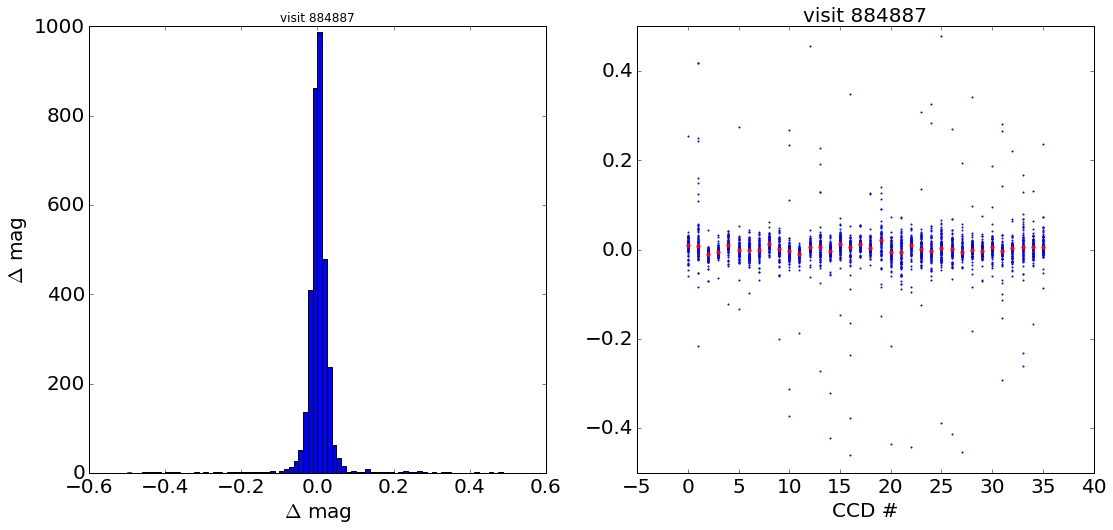

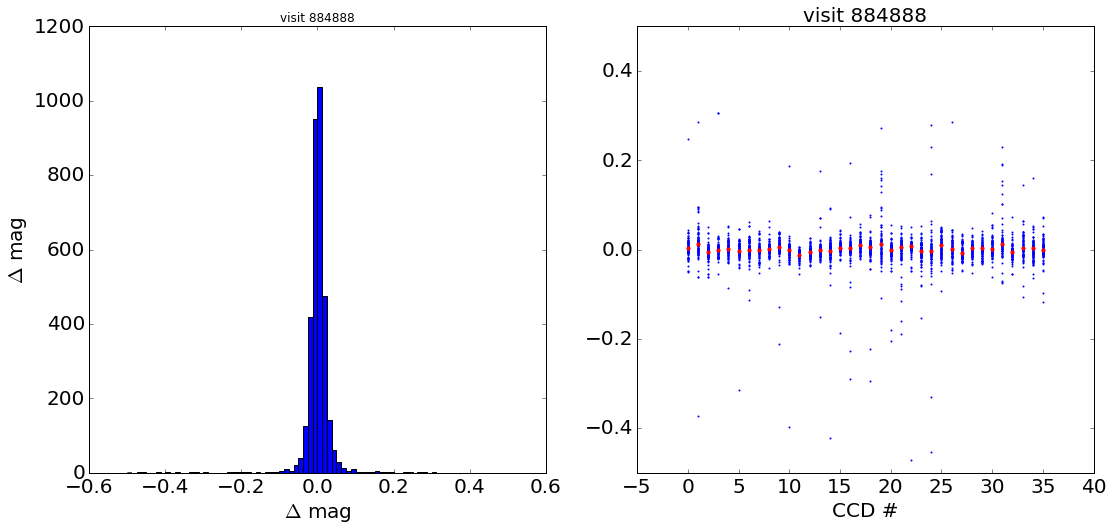

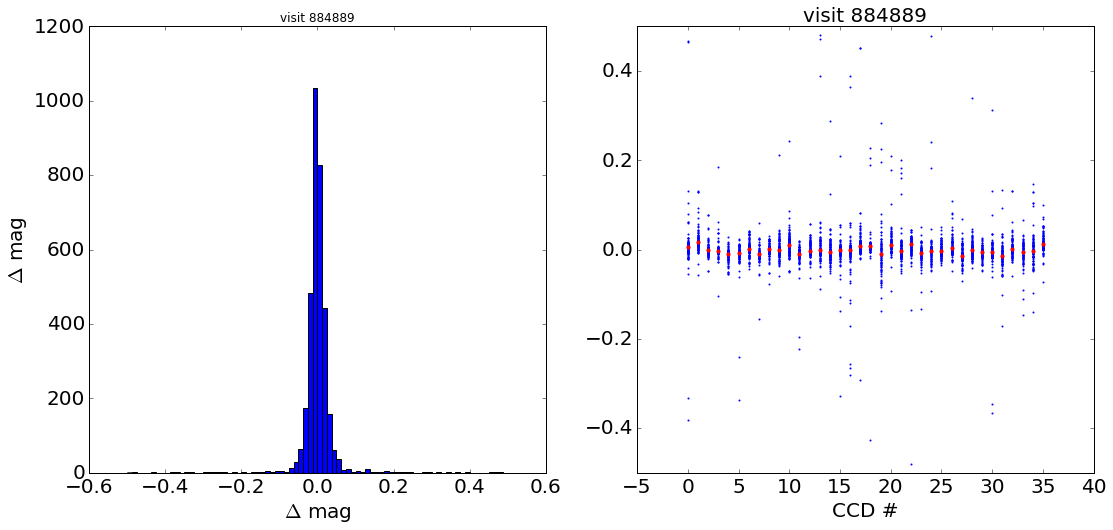

In [8]:
for v in visits :
    if v == ref :
        continue
    idx = np.where((np.asarray(_visits) == v) & (np.asarray(mag) < 22))
    ccd = np.asarray(_ccd)[idx]
    dmag = np.asarray(diffMag)[idx]
    med = [np.median(dmag[np.where(ccd==i)]) for i in range(36)]
    fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(18, 8))
    ax0.hist(np.asarray(diffMag)[idx], bins=80, range=[-0.5,0.5])
    ax0.set_title("visit %d"%(v))
    ax1.scatter(np.asarray(_ccd)[idx], np.asarray(diffMag)[idx], s=1, color='b')
    ax1.set_title("visit %d"%(v), fontsize=20)
    ax1.scatter(range(36), med, s=10, color='r')
    ax1.set_ylim([-0.5, 0.5])
    ax0.tick_params(labelsize=20)
    ax0.set_xlabel("$\Delta$ mag", fontsize=20)
    ax1.tick_params(labelsize=20)
    ax1.set_xlabel("CCD #", fontsize=20)
    ax0.set_ylabel("$\Delta$ mag", fontsize=20)

        
        

In [55]:
idx = np.where((np.asarray(_visits) == 860011) & (np.asarray(mag) < 22) & (np.asarray(_ccd) == 24))
#idx = np.where((np.asarray(_visits) == 967616) & (np.asarray(mag) < 22))
print np.asarray(_ccdR)[idx], np.asarray(_ccd)[idx]

[34 34 33 34 34 34 34 33 34 34 34 34 34 34 34 34 33 34 34 34 34 33 33 34] [24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24 24]


In [45]:
print np.asarray(diffMag)[idx], np.asarray(_ccd)[idx]

[  1.23826702e-01   1.23810888e-01  -2.60117059e-02 ...,  -1.44096789e-03
   4.66830366e-02   1.79274828e+00] [25 25 25 ...,  1  3  4]
